In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", message=".*defaulting to pandas implementation.*")
pd.set_option('display.float_format', '{:.6f}'.format)

# Import Model

In [2]:
jupyter_dir = os.path.abspath(str(Path()))
jupyter_dir

'E:\\git\\machine-learning-option-pricing'

In [3]:
models_path = os.path.join(jupyter_dir,'trained_models','trained_models')
models = os.listdir(models_path)
for i, path in enumerate(models):
    print(f"{i}   {path}")

0   .DS_Store
1   2024_10_09 23-01-12 Deep Neural Network otm
2   2024_10_09 23-11-23 Deep Neural Network
3   2024_10_10 11-56-07 Deep Neural Network
4   2024_10_10 12-04-22 Deep Neural Network
5   2024_10_11 10-19-52 Deep Neural Network
6   2024_10_11 11-25-11 Deep Neural Network
7   2024_10_11 12-08-00 Deep Neural Network
8   2024_10_11 12-45-52 Deep Neural Network
9   2024_10_11 17-10-51 Deep Neural Network
10   2024_10_12 01-15-59 Deep Neural Network


In [5]:
model = models[-1]
model

'2024_10_12 01-15-59 Deep Neural Network'

In [6]:
model_path = os.path.join(models_path,model)

In [7]:
model_files = os.listdir(model_path)
model_files

['2024_10_12 01-15-59 Deep Neural Network insample.csv',
 '2024_10_12 01-15-59 Deep Neural Network outsample.csv',
 '2024_10_12 01-15-59 Deep Neural Network.pkl',
 '2024_10_12 01-15-59 Deep Neural Network.txt']

In [8]:
spec_path = os.path.join(model_path,[file for file in model_files if file.endswith('.txt')][0])

In [9]:
import joblib

In [10]:
model_fit = joblib.load(os.path.join(model_path,[file for file in model_files if file.endswith('.pkl')][0]))

In [11]:
with open(spec_path, "r") as specs:
    for line in specs:
        print(line.strip())

Sat Oct 12 00:59:47 2024
spot(s):
[ 676.03  682.43  683.09  696.44  701.13  712.8   718.09  720.76  735.18
743.63  750.18  752.69  753.6   755.88  764.87  768.06  770.19  772.72
777.66  778.97  783.62  787.62  788.25  789.34  793.89  797.06  805.28
805.9   810.12  813.65  814.96  815.66  822.61  824.7   825.26  826.08
826.55  827.3   827.32  831.68  832.16  833.54  833.74  834.92  835.12
836.44  838.11  840.13  841.27  841.94  842.82  843.98  845.19  845.22
845.62  845.68  849.36  849.62  849.89  852.08  856.34  857.33  858.09
863.39  865.    865.04  868.15  868.97  869.08  869.57  869.78  870.18
870.82  871.38  871.64  871.84  872.49  873.75  873.87  876.65  879.73
885.33  887.22  888.94  890.17  890.47  895.24  898.8   899.16  903.41
904.15  906.79  908.76  909.78  911.39  913.19  919.06  927.54  930.68
931.03  934.45  952.69 1005.42 1156.65 1165.72 1187.4  1188.42 1195.66
1203.3  1207.56 1210.16 1213.76 1214.59 1214.91 1225.07 1228.34 1231.72
1235.03 1236.81 1240.01 1242.38 1244.81 

In [12]:
model_files

['2024_10_12 01-15-59 Deep Neural Network insample.csv',
 '2024_10_12 01-15-59 Deep Neural Network outsample.csv',
 '2024_10_12 01-15-59 Deep Neural Network.pkl',
 '2024_10_12 01-15-59 Deep Neural Network.txt']

In [13]:
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")
outsample_path = os.path.join(model_path,[file for file in model_files if file.find('outsample') != -1][0])
outsample = pd.read_csv(outsample_path).iloc[:,1:]

# Test Model

In [14]:
maturities = outsample['days_to_maturity'].unique().tolist()
barrier_type_names = outsample['barrier_type_name'].unique().tolist()
ws = outsample['w'].unique().tolist()
print(f"\nmaturities:\n     maturities = {maturities}")
print(f"\ntypes:\n     barrier_type_names = {barrier_type_names}\n     ws = {ws}\n")


maturities:
     maturities = [60, 90, 180, 360, 540, 720]

types:
     barrier_type_names = ['DownOut', 'DownIn', 'UpOut', 'UpIn']
     ws = ['put', 'call']



In [15]:
by_wbt = outsample.copy().set_index(['w','barrier_type_name','days_to_maturity']).sort_index()

In [16]:
RMSE = pd.DataFrame(
    np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
    columns = barrier_type_names,
    index = maturities
)

for t in maturities:
    for b in barrier_type_names:
        RMSE.loc[t,b] = np.sqrt(np.average((by_wbt.loc[(slice(None), b, t),'outofsample_error'])**2))
print(f"\nRMSE:\n{RMSE}")


RMSE:
     DownOut    DownIn    UpOut      UpIn
60  5.398571  3.904611 5.244338  4.424999
90  4.626015  4.011725 3.776252  4.568292
180 6.174942  3.682669 4.627395  5.214912
360 8.331243  6.809624 7.824928  7.330408
540 8.271934  9.860088 6.301370 11.095730
720 8.243704 11.226463 5.081405 12.176300


In [17]:
MAE = pd.DataFrame(
    np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
    index = maturities,
    columns = barrier_type_names
)
for t in maturities:
    for b in barrier_type_names:
        MAE.loc[t,b] = np.average(np.abs(by_wbt.loc[(slice(None), b, t),'outofsample_error']))
print(f"\nMAE:\n{MAE}")


MAE:
     DownOut   DownIn    UpOut     UpIn
60  4.413356 3.127644 4.193072 3.647426
90  3.708144 3.163325 2.896385 3.682675
180 5.075318 2.791689 3.753719 4.068559
360 6.255888 4.584058 5.799790 5.653659
540 5.869311 7.512680 4.736058 8.895263
720 5.983687 8.945033 3.872672 9.464501


In [18]:
errors_bypayoff = {}
for w in ws:
    errors = {}
    print(
        f"\n         {'#'*(len(w)+5)}"
        f"\n         # {w}s #"
        f"\n         {'#'*(len(w)+5)}"
    )
    RMSE = pd.DataFrame(
        np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
        columns = barrier_type_names
        )
    RMSE[w] = maturities
    RMSE = RMSE.set_index(w,drop=True)
    for t in maturities:
        for b in barrier_type_names:
            RMSE.loc[t,b] = np.sqrt(np.average((by_wbt.loc[(w, b, t),'outofsample_error'])**2))
    print(f"RMSE:\n{RMSE}")
    print()
    errors['RMSE'] = RMSE
    


    MAE = pd.DataFrame(
        np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
        columns = barrier_type_names
    )
    MAE[w] = maturities
    MAE = MAE.set_index(w,drop=True)
    for t in maturities:
        for b in barrier_type_names:
            MAE.loc[t,b] = np.average(np.abs(by_wbt.loc[(w, b, t),'outofsample_error']))
    print(f"MAE:\n{MAE}")
    print()
    errors['MAE'] = MAE
    errors_bypayoff[w] = errors


         ########
         # puts #
         ########
RMSE:
      DownOut    DownIn    UpOut     UpIn
put                                      
60   7.210858  3.340714 5.756478 4.116692
90   5.560434  3.783775 4.089974 5.030075
180  6.400302  4.166721 4.984763 5.776942
360  7.041231  6.966147 8.299356 6.042290
540  8.069079 10.169965 7.619514 7.316130
720 10.123412 12.029168 5.762343 7.257081

MAE:
     DownOut    DownIn    UpOut     UpIn
put                                     
60  6.773414  2.726373 4.627538 3.405888
90  4.424714  3.001925 3.086474 3.991217
180 5.033323  3.216857 4.259491 4.418366
360 4.671081  5.342641 7.019750 4.571344
540 4.972363  8.497771 6.509460 5.368049
720 7.174259 10.077876 4.888393 5.289415


         #########
         # calls #
         #########
RMSE:
      DownOut    DownIn    UpOut      UpIn
call                                      
60   2.897421  4.459175 4.615008  4.712521
90   3.571736  4.244351 3.397386  4.052689
180  5.962943  3.122914 4.198770

In [19]:
max_MAE = max(errors['MAE'].values.flatten())
max_RMSE = max(errors['RMSE'].values.flatten())
plot_height = max(max_RMSE,max_MAE)*1.05
maturities = errors['MAE'].index.astype(str).tolist()

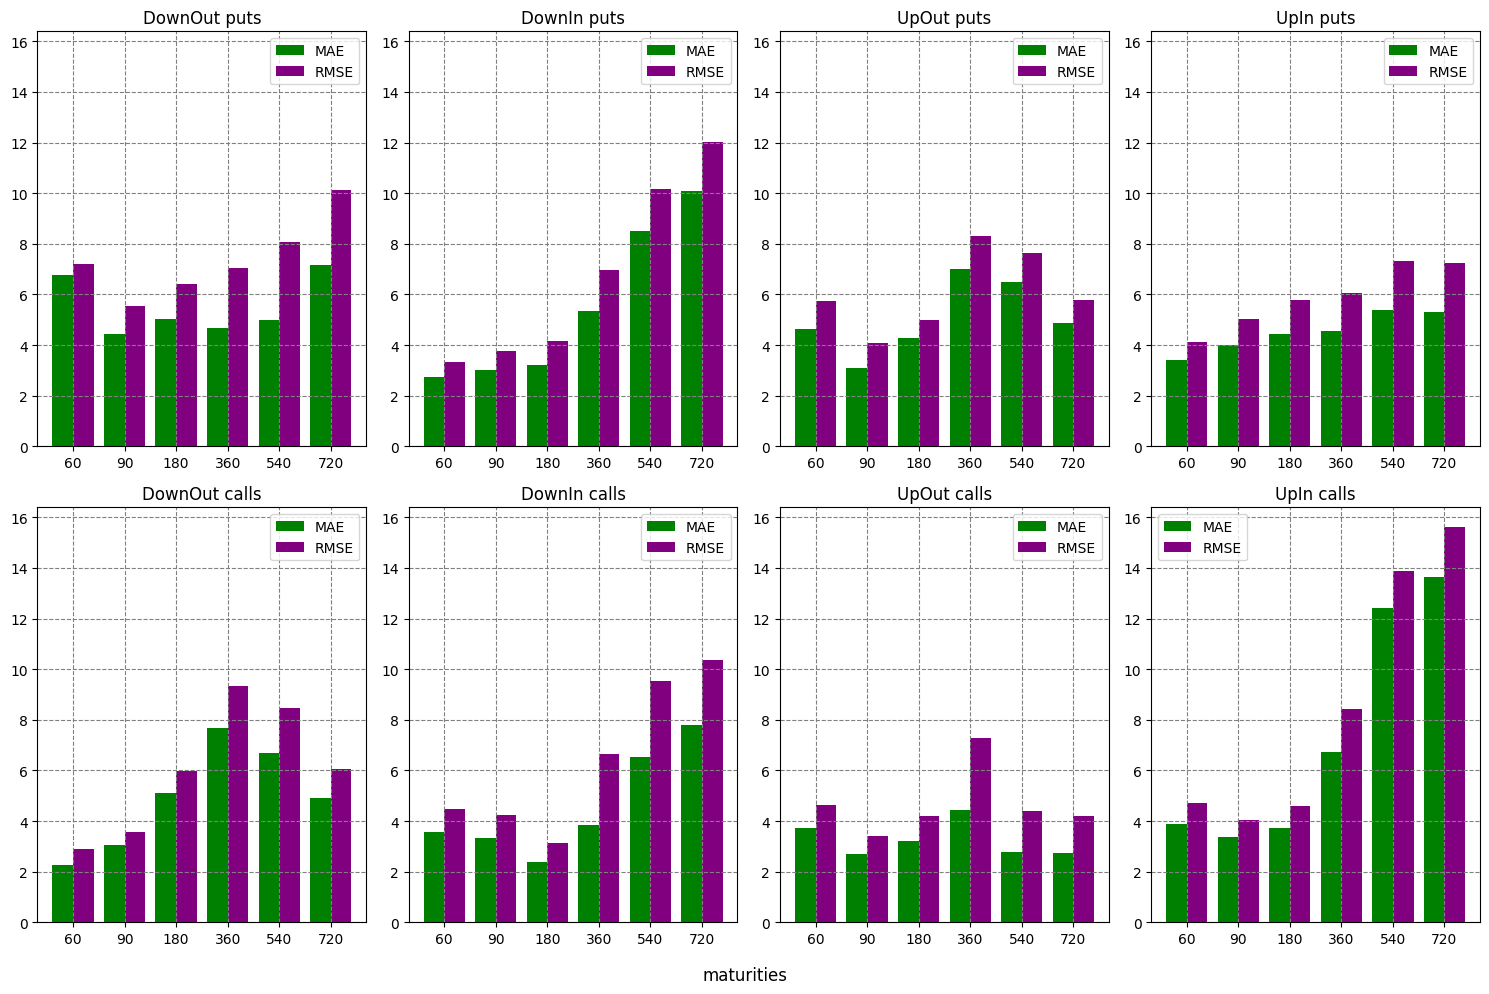

In [20]:
fig, axs = plt.subplots(2, 4, figsize=(15,10))
bar_width = 0.4
i = 0
for w, errors in errors_bypayoff.items():
    for b in barrier_type_names:

        MAE = errors['MAE'][b]
        RMSE = errors['RMSE'][b]
        x_positions = range(len(maturities))
        axs[i // 4, i % 4].grid(True,which='both', linestyle='--', color='gray')
        axs[i // 4, i % 4].bar(
            [x - 0.5 * bar_width for x in x_positions], MAE, width=bar_width, color='green',label="MAE"
        )
        
        axs[i // 4, i % 4].bar(
            [x + 0.5 * bar_width for x in x_positions], RMSE, width=bar_width, color='purple', label="RMSE"
        )
        axs[i // 4, i % 4].set_title(f'{b} {w}s')
        axs[i // 4, i % 4].set_xticks(x_positions)
        axs[i // 4, i % 4].set_xticklabels(maturities)
        axs[i // 4, i % 4].set_ylim(0, plot_height)
        axs[i // 4, i % 4].legend()
        i += 1

fig.supxlabel('maturities')

plt.tight_layout()
plt.show()

In [21]:
by_wbt.loc[('put','DownIn',slice(None)),:].describe()

,spot_price,strike_price,barrier,barrier_price,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,moneyness,observed_price,outofsample_target,outofsample_prediction,outofsample_error
count,141765.000000,141765.000000,141765.000000,141765.000000,141765.000000,141765.000000,141765.000000,141765.000000,141765.000000,141765.000000,141765.000000,141765.000000,141765.000000,141765.000000,141765.000000,141765.000000,141765.000000
mean,935.775249,936.203837,698.367255,54.495114,0.000000,0.024373,0.040000,0.085310,5.784764,-0.990754,0.195547,0.060816,-0.649063,54.499141,54.499141,51.946059,-2.553082
std,51.083780,75.227928,166.471160,46.280314,0.000000,0.001400,0.000000,0.015168,1.052676,0.020777,0.019105,0.023498,0.261970,46.275582,46.275582,41.958616,7.092117
min,832.580000,749.322000,416.290000,0.000020,0.000000,0.022014,0.040000,0.068525,3.877861,-1.000000,0.154510,0.027228,-0.947080,0.000000,0.000000,-1.339604,-40.875298
25%,898.580000,880.016286,560.816475,10.019078,0.000000,0.023119,0.040000,0.073296,5.074661,-1.000000,0.182556,0.041694,-0.903175,10.030201,10.030201,12.573390,-6.720339
50%,923.860000,933.704551,690.741650,46.487858,0.000000,0.024476,0.040000,0.082531,5.609980,-0.999987,0.192875,0.056193,-0.672637,46.489208,46.489208,43.954339,-0.860431
75%,982.260000,987.148633,846.450000,89.500325,0.000000,0.025234,0.040000,0.088317,6.138053,-0.999826,0.206309,0.071917,-0.420491,89.515565,89.515565,83.060096,2.295031
max,1030.720000,1133.792000,1020.412800,192.919960,0.000000,0.027886,0.040000,0.127648,9.849012,-0.907487,0.249729,0.126219,-0.039131,193.032899,193.032899,185.789816,20.554322


In [22]:
by_wbt.loc[('call','DownIn',slice(None)),:].describe()

,spot_price,strike_price,barrier,barrier_price,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,moneyness,observed_price,outofsample_target,outofsample_prediction,outofsample_error
count,137181.000000,137181.000000,137181.000000,137181.000000,137181.000000,137181.000000,137181.000000,137181.000000,137181.000000,137181.000000,137181.000000,137181.000000,137181.000000,137181.000000,137181.000000,137181.000000,137181.000000
mean,935.318400,932.362794,701.940137,23.213401,0.000000,0.024386,0.040000,0.085457,5.782318,-0.990863,0.195644,0.061050,4.795847,23.230037,23.230037,20.613473,-2.616564
std,51.082673,73.717964,166.819957,40.918077,0.000000,0.001402,0.000000,0.015245,1.048387,0.020676,0.019108,0.023586,5.033506,40.908708,40.908708,36.067575,6.531688
min,832.580000,749.322000,416.290000,0.000005,0.000000,0.022014,0.040000,0.068525,3.877861,-1.000000,0.154510,0.027228,0.040725,0.000000,0.000000,-3.490560,-37.634724
25%,898.580000,877.272122,563.804475,0.052157,0.000000,0.023149,0.040000,0.073350,5.074661,-1.000000,0.182556,0.042328,0.708185,0.089885,0.089885,-0.221136,-4.077517
50%,923.860000,929.755224,699.711450,0.874523,0.000000,0.024476,0.040000,0.082717,5.609980,-0.999987,0.192875,0.056262,1.869808,0.889839,0.889839,5.014038,-1.414623
75%,979.830000,982.043327,849.881075,28.955410,0.000000,0.025234,0.040000,0.088317,6.138053,-0.999844,0.206309,0.071917,8.999623,28.958893,28.958893,22.622557,1.133410
max,1030.720000,1133.792000,1020.412800,199.175306,0.000000,0.027886,0.040000,0.127648,9.849012,-0.907487,0.249729,0.126219,17.896533,199.098988,199.098988,192.226509,7.511556


In [23]:
types  = ['DownOut', 'DownIn', 'UpOut', 'UpIn']

In [24]:
for b in types:
    print(f"\n{b}")
    print(by_wbt.loc[('call',b,slice(None)),:].shape[0])


DownOut
142500

DownIn
137181

UpOut
129390

UpIn
140941


In [25]:
types  = ['DownOut', 'DownIn', 'UpOut', 'UpIn']
for b in types:
    print(f"\n{b}")
    print(by_wbt.loc[('put',b,slice(None)),:].shape[0])


DownOut
129390

DownIn
141765

UpOut
142500

UpIn
140955


In [26]:
outsample.loc[:,'security_type'] = outsample['w'] + outsample['barrier_type_name']

In [27]:
down_calls = outsample.copy()[
    (
        (outsample['w'] == 'call')
        &
        (outsample['updown'] =='Down')
    )
]
observed_price = np.sum(down_calls['barrier_price'])
outofsample_prediction = np.sum(down_calls['outofsample_prediction'])
print(f"\n{observed_price}\n{outofsample_prediction}\n")
RMSE = float(np.sqrt(np.mean(np.array(down_calls['outofsample_prediction']-down_calls['barrier_price'])**2)))
print(RMSE)
MAE = float(np.average(np.abs(np.array(down_calls['outofsample_prediction']-down_calls['barrier_price']))))
MAE


13709494.780970538
12896217.278944964

6.7578623061899705


4.784453778620662

In [28]:
down_puts = outsample.copy()[
    (
        (outsample['w'] == 'put')
        &
        (outsample['updown'] =='Down')
    )
]
observed_price = np.sum(down_puts['barrier_price'])
outofsample_prediction = np.sum(down_puts['outofsample_prediction'])
print(f"\n{observed_price}\n{outofsample_prediction}\n")
RMSE = float(np.sqrt(np.mean(np.array(down_puts['outofsample_prediction']-down_puts['barrier_price'])**2)))
print(RMSE)
MAE = float(np.average(np.abs(np.array(down_puts['outofsample_prediction']-down_puts['barrier_price']))))
MAE


11918628.541858776
11612221.654493706

7.5391427140515805


5.501976821083905

In [29]:
up_calls = outsample.copy()[
    (
        (outsample['w'] == 'call')
        &
        (outsample['updown'] =='Up')
    )
]
observed_price = np.sum(up_calls['barrier_price'])
outofsample_prediction = np.sum(up_calls['outofsample_prediction'])
print(f"\n{observed_price}\n{outofsample_prediction}\n")
RMSE = float(np.sqrt(np.mean(np.array(up_calls['outofsample_prediction']-up_calls['barrier_price'])**2)))
print(RMSE)
MAE = float(np.average(np.abs(np.array(up_calls['outofsample_prediction']-up_calls['barrier_price']))))
MAE


13709467.433632465
13152162.280063335

7.804228995285061


5.387159528225074

In [30]:
up_puts = outsample.copy()[
    (
        (outsample['w'] == 'put')
        &
        (outsample['updown'] =='Up')
    )
]
observed_price = np.sum(up_puts['barrier_price'])
outofsample_prediction = np.sum(up_puts['outofsample_prediction'])
print(f"\n{observed_price}\n{outofsample_prediction}\n")
RMSE = float(np.sqrt(np.mean(np.array(up_puts['outofsample_prediction']-up_puts['barrier_price'])**2)))
print(RMSE)
MAE = float(np.average(np.abs(np.array(up_puts['outofsample_prediction']-up_puts['barrier_price']))))
MAE


11918628.026179964
11179522.978054728

6.1504750482530355


4.788120314733779